In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
seed = 42
import dmeq

In [2]:
import jax.numpy as jnp
from jax import pmap, vmap, jit, random, value_and_grad

In [3]:
key = random.PRNGKey(seed)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
import haiku as hk
import optax

In [5]:
from scipy.stats.qmc import LatinHypercube

In [6]:
n_samples = int(1e3)

bounds = pd.DataFrame.from_records([
    ('EIR', 0, 100),
    ('eta', 1/(40 * 365), 1/(20 * 365)),
    ('Q0', 0, 1),
    ('s2', 1, 3),
    ('rU', 1/1000, 1/30),
    ('cD', 0, 1),
    ('g_inf', 0.01, 10),
    ('cU', 0, 1),
    ('kb', 0.01, 10),
    ('ub', 1, 10),
    ('uc', 1, 10),
    ('ud', 1, 10),
    ('kc', .01, 10),
    ('b0', .01, .99),
    ('b1', .01, .99),
    ('IB0', 1, 100),
    ('IC0', 1, 100),
    ('ID0', 1, 100),
    ('tau', 1, 20),
    ('phi0', 0, 1),
    ('phi1', 0, 1),
    ('mu', 0, 1),
    ('f', 0, 1),
    ('fd0', 0, 1),
    ('ad0', 20 * 365, 40 * 365),
    ('gd', 1, 10),
    ('PM', 0, 1),
    ('dm', 0, 1000)
], columns=['name', 'lower', 'upper'])

sampler = LatinHypercube(d=len(bounds), seed=42)

samples = sampler.random(n_samples)

samples = samples * (bounds.upper - bounds.lower).to_numpy() + bounds.lower.to_numpy()

In [7]:
jsamples = jnp.array(samples)
batched_samples = jnp.reshape(
    jsamples,
    (cpu_count, int(jsamples.shape[0] / cpu_count)) + jsamples.shape[1:]
)

In [8]:
param_keys = list(bounds['name'])
p = dmeq.default_parameters()

@jit
def run_eq(params):
    local_p = p.copy()
    for i in range(len(param_keys)):
        local_p[param_keys[i]] = params[i]
    return dmeq.solve(local_p, dtype=jnp.float64)

runner = pmap(vmap(run_eq, in_axes=0), in_axes=0)

results = runner(batched_samples)
results = jnp.reshape(results, (jsamples.shape[0], -1))

In [9]:
rand_index = random.permutation(key, n_samples, independent=True)
cut = int(n_samples * 0.8)
idx_train, idx_test = rand_index[:cut], rand_index[cut:] 

In [10]:
result_ranges = [
    (0, 100), # prev
    (100, 200), # inc
    (200, 300) # prop
]

result_stats = [
    (
        jnp.mean(results[idx_train,lower:upper], axis=None),
        jnp.std(results[idx_train,lower:upper], axis=None)
    )
    for lower, upper in result_ranges
]

standard_results = jnp.concatenate([
    (results[:,result_ranges[i][0]:result_ranges[i][1]] - result_stats[i][0]) / result_stats[i][1]
    for i in range(len(result_ranges))
], axis=1)

In [11]:
sample_mean, sample_std = jnp.mean(samples[idx_train], axis=0), jnp.std(samples[idx_train], axis=0)
standard_samples = (samples - sample_mean) / sample_std

In [12]:
X_train = standard_samples[idx_train]
y_train = standard_results[idx_train]
X_test = standard_samples[idx_test]
y_test = standard_results[idx_test]

In [13]:
def _model(x):
    return hk.nets.MLP(
        output_sizes = [288] * 3 + [y_train.shape[1]],
        w_init = hk.initializers.Orthogonal(),
    )(x)

model = hk.without_apply_rng(hk.transform(_model))

In [58]:
params = model.init(rng=key, x=X_train)

In [15]:
def _spectral_normaliser(x):
    return hk.SNParamsTree(ignore_regex='^.*b$')(x)

spectral_normaliser = hk.without_apply_rng(hk.transform_with_state(_spectral_normaliser))

In [16]:
key, key_i = random.split(key)
sn_params, sn_state = spectral_normaliser.init(rng=key_i, x=params)

In [59]:
from jax.nn import softplus

@jit
def log_cosh(params, x_batched, y_batched):
    # Define a numerically stable log cosh for a single pair (x,y)
    def error(x, y):
        pred = model.apply(params, x)
        diff = y - pred
        return jnp.mean(diff + softplus(-2 * diff) - jnp.log(2.))
    # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(vmap(error)(x_batched, y_batched), axis=0)

def orthogonal_regulariser(params, weight=0.001):
    return jnp.sum(jnp.array([
        jnp.sum(jnp.abs(jnp.matmul(p['w'], p['w'].T) - jnp.eye(p['w'].shape[0])))
        for p in params.values()
    ])) * weight

@jit
def regularised_loss(params, x_batched, y_batched):
    return log_cosh(params, x_batched, y_batched) + orthogonal_regulariser(params, 1e-3)

In [60]:
tx = optax.adam(learning_rate=.001)
opt_state = tx.init(params)
loss_grad_fn = value_and_grad(regularised_loss)

In [46]:
batch_size = 100
n_batches = X_train.shape[0] // batch_size
X_train_batched = jnp.reshape(
    X_train,
    (n_batches, batch_size) + X_train.shape[1:]
)
y_train_batched = jnp.reshape(
    y_train,
    (n_batches, batch_size) + y_train.shape[1:]
)

In [61]:
%%time
epochs = 500

for i in range(epochs):
    key, key_i = random.split(key)
    for b in random.permutation(key_i, n_batches, independent=True):
        loss_val, grads = loss_grad_fn(params, X_train_batched[b], y_train_batched[b])
        updates, opt_state = tx.update(grads, opt_state)
        #params, sn_state = spectral_normaliser.apply(sn_params, sn_state, params)
        params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), regularised_loss(params, X_train, y_train))

Loss step 0:  0.5075107460417552
Loss step 10:  0.24589735881389577
Loss step 20:  0.194157730518158
Loss step 30:  0.17637174740863612
Loss step 40:  0.16852262020124406
Loss step 50:  0.16342430998517563
Loss step 60:  0.1599079728165051
Loss step 70:  0.15711382952647546
Loss step 80:  0.15519048144575784
Loss step 90:  0.1532814116282498
Loss step 100:  0.15197892803903845
Loss step 110:  0.15098941010381658
Loss step 120:  0.1499785538997378
Loss step 130:  0.14890376536112354
Loss step 140:  0.14828198275766988
Loss step 150:  0.1473523487640581
Loss step 160:  0.1467021146794205
Loss step 170:  0.14557857485400816
Loss step 180:  0.1448437237676377
Loss step 190:  0.14351499124236836
Loss step 200:  0.1415024117542062
Loss step 210:  0.1395826643535781
Loss step 220:  0.13766322067878883
Loss step 230:  0.13536249254632746
Loss step 240:  0.13351015323260906
Loss step 250:  0.1329044271356562
Loss step 260:  0.13104639472012766
Loss step 270:  0.13038789903306905
Loss step 280: 

In [62]:
[(n, jnp.linalg.norm(p['w'], 2)) for n, p in params.items()]

[('mlp/~/linear_0', Array(1.8551548, dtype=float64)),
 ('mlp/~/linear_1', Array(1.00533968, dtype=float64)),
 ('mlp/~/linear_2', Array(1.00491025, dtype=float64)),
 ('mlp/~/linear_3', Array(3.33625419, dtype=float64))]

In [63]:
batch_predict = vmap(jit(lambda y: model.apply(params, y)))
y_hat = batch_predict(X_test)

In [64]:
def inverse_standardise(x):
    return jnp.concatenate([
        x[:,result_ranges[i][0]:result_ranges[i][1]] * result_stats[i][1] + result_stats[i][0]
        for i in range(len(result_ranges))
    ], axis=1)

In [65]:
def prev_2_10(y):
    return jnp.sum(y[:,2:10], axis=1) / jnp.sum(y[:,202:210], axis=1)

def inc_0_5(y):
    return jnp.sum(y[:,100:105], axis=1) / jnp.sum(y[:,200:205], axis=1)

Text(0, 0.5, 'true prev_2_10')

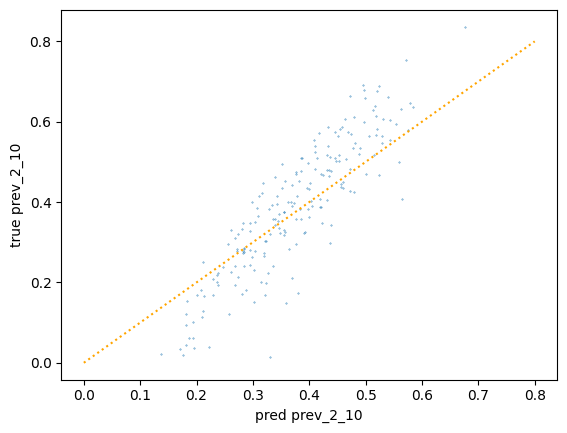

In [66]:
plt.scatter(prev_2_10(inverse_standardise(y_hat)), prev_2_10(inverse_standardise(y_test)), s=0.1)
plt.plot(np.linspace(0, 0.8), np.linspace(0, 0.8), linestyle=':', color='orange')
plt.xlabel('pred prev_2_10')
plt.ylabel('true prev_2_10')

Text(0, 0.5, 'true inc_0_5')

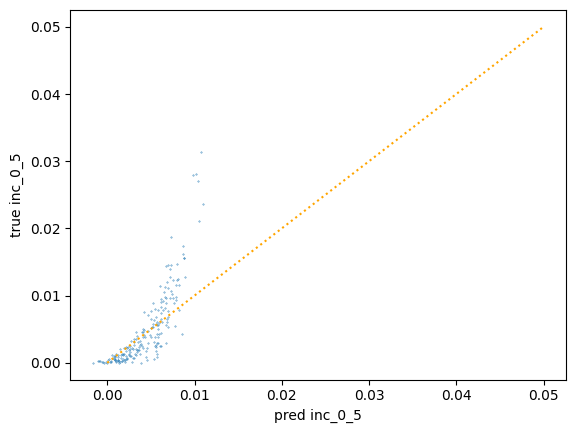

In [67]:
plt.scatter(inc_0_5(inverse_standardise(y_hat)), inc_0_5(inverse_standardise(y_test)), s=0.1)
plt.plot(np.linspace(0, 0.05), np.linspace(0, 0.05), linestyle=':', color='orange')
plt.xlabel('pred inc_0_5')
plt.ylabel('true inc_0_5')

In [31]:
import pickle
from dataclasses import dataclass
from typing import Any, Sequence
from jaxtyping import PyTree, Float, Array

In [68]:
@dataclass
class Surrogate():
    model: Any
    params: PyTree
    param_keys: Sequence[str]
    param_stats: Sequence[Float[Array, 'input_dim']]
    output_ranges: Sequence[Sequence[int]]
    output_stats: Sequence[Sequence[Float[Array, 'output_dim']]]
    
    def run(self, p):
        input_array = jnp.array([p[k] for k in self.param_keys])
        standardised_input = (input_array - self.param_stats[0]) / self.param_stats[1]
        output = self.model.apply(self.params, standardised_input)
        standardised_result = jnp.concatenate([
            output[self.output_ranges[i][0]:self.output_ranges[i][1]] *
                self.output_stats[i][1] + self.output_stats[i][0]
            for i in range(len(self.output_ranges))
        ])
        return jnp.reshape(
            standardised_result,
            (
                len(self.output_ranges),
                (self.output_ranges[0][1] - self.output_ranges[0][0])
            )
        )

In [69]:
s = Surrogate(
    model=model,
    params=params,
    param_keys=bounds['name'],
    param_stats=(sample_mean, sample_std),
    output_ranges=result_ranges,
    output_stats=result_stats
)

In [70]:
with open('eq_surrogate', 'wb') as f:
    pickle.dump(s, f)

AttributeError: Can't pickle local object 'without_state.<locals>.init_fn'

In [35]:
import dmeq

In [36]:
def prev_stats(params, eir, eta, impl):
    p = dmeq.default_parameters()
    (
        p['kb'],
        # p['ub'],
        p['b0'],
        # p['IB0'],
        # p['kc'],
        # p['uc'],
        # p['IC0'],
        # p['phi0'],
        # p['phi1'],
        # p['PM'],
        # p['dm'],
        # p['kd'],
        # p['ud'],
        # p['d1'],
        # p['ID0'],
        # p['fd0'],
        # p['gd'],
        # p['ad0'],
        # p['rU'],
        # p['cD'],
        # p['cU'],
        # p['g_inf']
    )= params
    p['EIR'] = eir
    p['eta'] = eta
    solution = impl(p)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [37]:
population = 100_000
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
etas = 1. / (random.normal(key, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)
def prev(b0, kb, impl):
    return prev_stats([b0, kb], EIRs[0], etas[0], impl)[0]

In [71]:
n = 50
b0 = jnp.linspace(0, 1, num=n)
kb = jnp.linspace(0, 5, num=n)
b0, kb = jnp.meshgrid(b0, kb)
surr_prev_space, surr_prev_grad = vmap(
    vmap(
        value_and_grad(prev),
        in_axes=(0, 0, None),
        out_axes=0
    ),
    in_axes=(1, 1, None),
    out_axes=1
)(b0, kb, s.run)

In [41]:
from matplotlib import cm

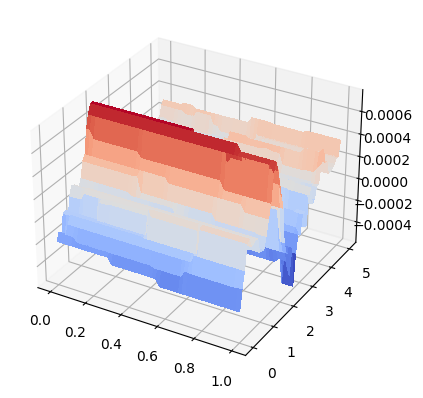

In [72]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, surr_prev_grad, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)